In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

Torch:  1.0.0
Torchvision:  0.2.1
sklearn:  0.20.1
Python:  3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


In [2]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

Torch Cuda not avaialbe


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *

In [5]:
PATH = '../../../../../data/DogBreeds/'

In [6]:
import os
print(os.listdir(PATH))

['train', 'test.zip', 'test', 'labels.csv', 'sample_submission.csv', 'train.zip']


In [11]:
print(os.listdir(PATH+'test'))

['ec5329231ea816ef212b367bdd17d06c.jpg', '33fdf388402e678d94203911ec26c63e.jpg', '6acc281a51e906efd3e7b083ffe30894.jpg', '5dd0213b5436227a2337c1f6f0d966b6.jpg', 'c474ec93ff7760ace34ca042f747231c.jpg', '71d8ea950f6312b766d75d6ad8ac3ba2.jpg', 'b0af8261078235519a15edf051e083b3.jpg', '578d0c49dc9132811627498a46a6281e.jpg', 'd18e7f2e252bc32d7f6ad2f717273e2f.jpg', 'e6ec1891d8f52a13683c73cabd3045cb.jpg', 'ba46139495a97d58b858a63e672a8938.jpg', 'b9246b71e7cd67f936b838ec3323e39f.jpg', 'f8017854f9f52f53140234f44cd335f8.jpg', '40e29c101b5bc33e9e252bf850a9aa76.jpg', 'b37feba190b9cb8663d75afd5ec22c1c.jpg', '1509e27988119ea9293c2df2fc1b4b45.jpg', '1bd6335be3bc749a6d1a8f7582349ae6.jpg', 'c98d79e7501ae25f5420ba77b89306cf.jpg', '27ee48039c475345d1d24103d0b4fcb9.jpg', 'eb9aebedf9ed7d768a5afb36cd0e2436.jpg', 'c90109fe5971384b82dc9d4085609d5b.jpg', '29295256a8805d4bbcd2acf7b73af052.jpg', '551ce3484383dc77bd5cb563a50bad46.jpg', 'a4efca215aa78084b7f26ff1eb38c82e.jpg', 'c0cf45d6873058e0fa2b5d12bd8d41a8.jpg',

In [8]:
from zipfile import ZipFile
files = os.listdir(PATH)
if not 'train.zip' in files:
    !kaggle competitions download -c dog-breed-identification -p PATH
if not 'train' in files:    
    for file in files:
        with ZipFile(PATH+file, 'r') as zipF:
            zipF.extractall(path=PATH)
            print(file,': Done')
os.listdir(PATH)        

['train',
 'test.zip',
 'test',
 'labels.csv',
 'sample_submission.csv',
 'train.zip']

In [13]:
data = ImageDataBunch.from_csv(PATH, folder='train', ds_tfms=get_transforms(), size=224,suffix='.jpg', bs=32).normalize(imagenet_stats)

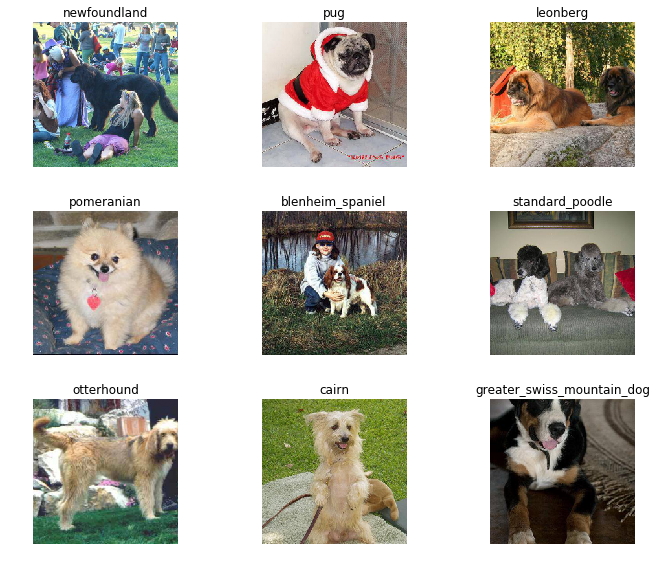

In [14]:
data.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Valid)

In [15]:
print(data.classes)
len(data.classes),data.c

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

(120, 120)